# 1.Autoencoder

In [1]:
import keras
from keras.datasets import cifar10
from keras import layers, models
from keras.layers import Input, Activation, BatchNormalization, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

### Load the CIFAR10 dataset

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

In [7]:
def create_block(input, chs):
    """A helper function to create convolution block of 2 layers"""
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

### Build and fit the convolutional autoencoder

In [2]:
def general_ae():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    
    #Middle
    middle = create_block(x, 128)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    #up1 = UpSampling2D((2,2))(block3)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    #up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [24]:
encoder_ae, model_ae = general_ae()

In [25]:
model_ae.compile(optimizer='adam', loss='binary_crossentropy')

In [30]:
model_ae.fit(x_train, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 522s 10ms/step - loss: 0.5613 - val_loss: 0.5624
Epoch 2/2
50000/50000 [==============================] - 541s 11ms/step - loss: 0.5605 - val_loss: 0.5608


In [31]:
recon_ae = model_ae.predict(x_test)

### Visualize some examples of input images and their decoded reconstruction

In [32]:
def showOrigDec(orig, dec, num=10):  
    """Helper function used for visualizing original and reconstructed images of the autoencoder model"""
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[300*i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[300*i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

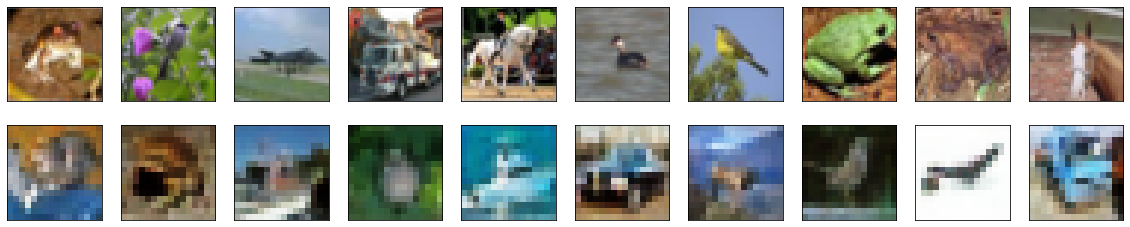

In [33]:
showOrigDec(x_train, recon_ae)

# 2. Image Classification

## 2.1 Deep CNN

### Load, normalize and explore the data

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
#Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

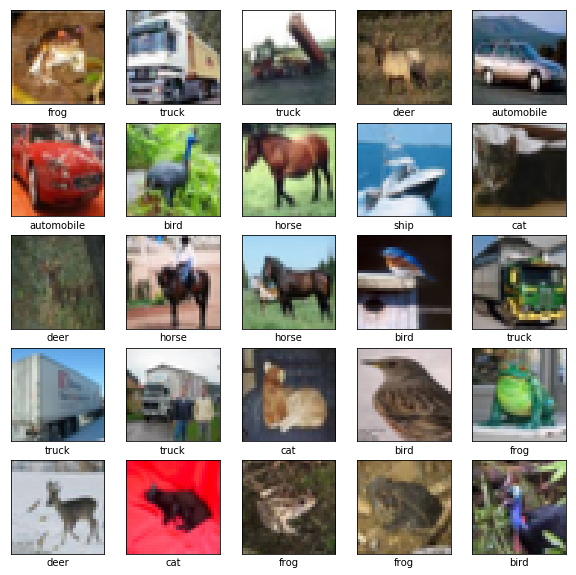

In [44]:
#Plot the first 25 images from the training set and display the class name below each image.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Train and fit the deep CNN model

In [40]:
model = models.Sequential()
#block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#block 3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#flatten
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [41]:
#Display the architecture of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.Then we flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so we use a final Dense layer with 10 outputs and a softmax activation.Finally, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

In [43]:
#Compile and train the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 44s 877us/step - loss: 1.5160 - accuracy: 0.4466 - val_loss: 1.3133 - val_accuracy: 0.5269
Epoch 2/10
50000/50000 [==============================] - 49s 975us/step - loss: 1.1720 - accuracy: 0.5869 - val_loss: 1.1261 - val_accuracy: 0.5967
Epoch 3/10
50000/50000 [==============================] - 44s 890us/step - loss: 1.0265 - accuracy: 0.6388 - val_loss: 1.0112 - val_accuracy: 0.6435
Epoch 4/10
50000/50000 [==============================] - 44s 885us/step - loss: 0.9316 - accuracy: 0.6726 - val_loss: 0.9577 - val_accuracy: 0.6683
Epoch 5/10
50000/50000 [==============================] - 45s 891us/step - loss: 0.8640 - accuracy: 0.6971 - val_loss: 0.9247 - val_accuracy: 0.6811
Epoch 6/10
50000/50000 [==============================] - 45s 909us/step - loss: 0.8045 - accuracy: 0.7179 - val_loss: 0.9204 - val_accuracy: 0.6833
Epoch 7/10
50000/50000 [==============================] 

### Evaluate the model

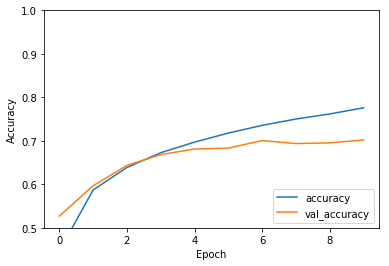

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [46]:
print("Test accuracy: ",test_acc)

Test accuracy:  0.7020999789237976


## 2.2 Transfer Learning

In [ ]:
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (32, 32, 3), classes = 10)

# Preprocessing the input 
X_train = preprocess_input(train_images)
X_test = preprocess_input(test_images)

# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=256, verbose=1)

# Flatten extracted features
train_features = np.reshape(train_features, (48000, 4*4*512))
test_features = np.reshape(test_features, (10000, 4*4*512))
val_features = np.reshape(val_features, (12000, 4*4*512))

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# 3. Text Classification

## 3.1 RNN

In [53]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

### Load the data

In [51]:
df = pd.read_csv("SPAM_detection.csv")

In [61]:
texts = np.asarray(df.Message)
labels = np.asarray(df.category_val)

### Train-test split

In [62]:
# number of words used as features
max_features = 10000
# cut off the words after seeing 500 words in each document(email)
maxlen = 500
# train: 70%; test: 30% 
training_samples = int(5572 * .7)
validation_samples = int(5572 - training_samples)

In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

In [64]:
data = pad_sequences(sequences, maxlen=maxlen)

print("data shape: ", data.shape)

data shape:  (5572, 500)


In [65]:
# shuffle data
np.random.seed(613)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


texts_train = data[:training_samples]
y_train = labels[:training_samples]
texts_test = data[training_samples:]
y_test = labels[training_samples:]

### Train the model: LSTM

In [69]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_ltsm = model.fit(texts_train, y_train, epochs=10, batch_size=60, validation_split=0.2)

C:\Users\zhuyi\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zhuyi\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.3174 - acc: 0.8734 - val_loss: 0.1765 - val_acc: 0.9333
Epoch 2/10
3120/3120 [==============================] - 11s 3ms/step - loss: 0.1145 - acc: 0.9705 - val_loss: 0.0919 - val_acc: 0.9756
Epoch 3/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.0563 - acc: 0.9881 - val_loss: 0.0670 - val_acc: 0.9808
Epoch 4/10
3120/3120 [==============================] - 11s 3ms/step - loss: 0.0336 - acc: 0.9939 - val_loss: 0.0510 - val_acc: 0.9821
Epoch 5/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.0217 - acc: 0.9939 - val_loss: 0.0494 - val_acc: 0.9859
Epoch 6/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.0219 - acc: 0.9952 - val_loss: 0.0753 - val_acc: 0.9795
Epoch 7/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.0220 - acc: 0.9942 - val_loss: 0.0454 - val_acc: 0.9833
Epoch 8/

### Evaluate the model

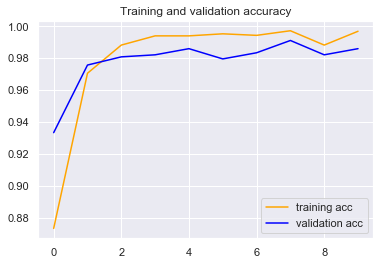

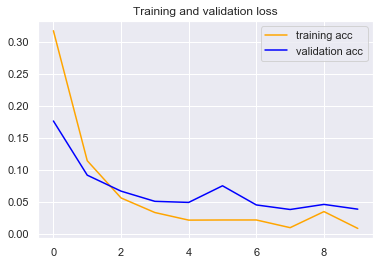

In [70]:
acc = history_ltsm.history['acc']
val_acc = history_ltsm.history['val_acc']
loss = history_ltsm.history['loss']
val_loss = history_ltsm.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [71]:
acc = model.evaluate(texts_test, y_test)
proba_ltsm = model.predict_proba(texts_test)
from sklearn.metrics import confusion_matrix
print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
print(confusion_matrix(pred, y_test))

1672/1672 [==============================] - 2s 1ms/step
Test loss is 0.06 accuracy is 0.98  
[[1422   38]
 [  17  195]]


## 3.2 CNN

### Padding

In [82]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(texts_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(texts_test, padding='post', maxlen=maxlen)

### Train the model

In [83]:
vocab_size = len(word_index)+1
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          900500    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 965,929
Trainable params: 965,929
Non-trainable params: 0
_________________________________________________________________


### Evaluate the model

In [88]:
cnn_history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9868


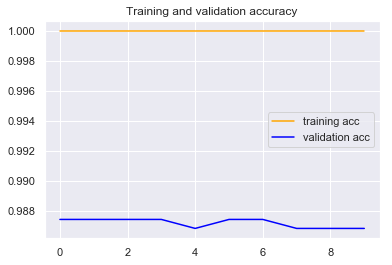

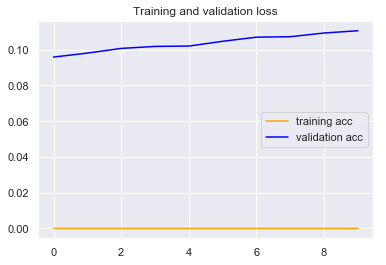

In [91]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Based on the results, CNN performs better than RNN. CNN has around 98.8% accuracy from the first epoch to the last one, but RNN reaches 98% accuracy at the second epoch.